## Loading the data

In [11]:
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os 

sc.set_figure_params(dpi=100, frameon=False,fontsize=12)
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [12]:
os.getcwd()

'/home/mo/projects/test_AdvAE/Norman_results'

In [13]:
adata = sc.read('../datasets/Norman2019_prep_new.h5ad')

In [14]:
os.chdir("../")

In [15]:
from compert.helper import rank_genes_groups_by_cov

In [16]:
rank_genes_groups_by_cov(adata, groupby='cov_drug_dose_name', covariate='cell_type', control_group='ctrl_1', n_genes=100)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


A549


In [17]:
adata.write("./datasets/Norman2019_prep_new_new.h5ad")

In [18]:
import torch
from compert.train import prepare_compert

In [19]:
os.getcwd()

'/home/mo/projects/test_AdvAE'

In [20]:
from os import listdir
from os.path import isfile, join
PATH = "./pretrained_models/Norman2019_prep_new_deg_collect/relu/"
onlyfiles = [f for f in listdir(PATH) if isfile(join(PATH, f))]

In [21]:
from sklearn.metrics import r2_score


In [22]:
def evaluate_r2(autoencoder, dataset, genes_control):
    """
    Measures different quality metrics about an ComPert `autoencoder`, when
    tasked to translate some `genes_control` into each of the drug/cell_type
    combinations described in `dataset`.

    Considered metrics are R2 score about means and variances for all genes, as
    well as R2 score about means and variances about differentially expressed
    (_de) genes.
    """

    pert , mean_score, var_score, mean_score_de, var_score_de = [], [], [], [], []
    num, dim = genes_control.size(0), genes_control.size(1)

    total_cells = len(dataset)

    for pert_category in np.unique(dataset.pert_categories):
        # pert_category category contains: 'celltype_perturbation_dose' info
        de_idx = np.where(
            dataset.var_names.isin(
                np.array(dataset.de_genes[pert_category])))[0]
        pert.append(pert_category)
        idx = np.where(dataset.pert_categories == pert_category)[0]

        emb_drugs = dataset.drugs[idx][0].view(
            1, -1).repeat(num, 1).clone()
        emb_cts = dataset.cell_types[idx][0].view(
            1, -1).repeat(num, 1).clone()

        genes_predict = autoencoder.predict(
            genes_control, emb_drugs, emb_cts).detach().cpu()

        mean_predict = genes_predict[:, :dim]
        var_predict = genes_predict[:, dim:]

        # estimate metrics only for reasonably-sized drug/cell-type combos

        y_true = dataset.genes[idx, :].numpy()

        # true means and variances
        yt_m = y_true.mean(axis=0)
        yt_v = y_true.var(axis=0)
        # predicted means and variances
        yp_m = mean_predict.mean(0)
        yp_v = var_predict.mean(0)

        mean_score.append(r2_score(yt_m, yp_m))
        var_score.append(r2_score(yt_v, yp_v))

        mean_score_de.append(r2_score(yt_m[de_idx], yp_m[de_idx]))
        var_score_de.append(r2_score(yt_v[de_idx], yp_v[de_idx]))
        
    df = pd.DataFrame({"pert_name":pert,
                       "mean": mean_score, 
                       "mean_DEGs": mean_score_de, 
                       "var": var_score,
                       "var_DEGs":var_score_de})
    return df

In [23]:
import pandas as  pd

In [24]:
from compert.data import load_dataset_splits

In [25]:
os.getcwd()

'/home/mo/projects/test_AdvAE'

In [26]:
state, args, metrics = torch.load(f'./pretrained_models/Norman2019_prep_new_deg_collect/relu/sweep_Norman2019_prep_new_relu_model_seed=16_epoch=80.pt', map_location=torch.device('cpu'))
args['dataset_path'] = './datasets/Norman2019_prep_new_new.h5ad'
args['save_dir'] = '/ckpts'
model, datasets = prepare_compert(args, state_dict=state)
datasets, full_dataset = load_dataset_splits(
    dataset_path=args['dataset_path'],
    perturbation_key=args['perturbation_key'],
    dose_key=args['dose_key'],
    cell_type_key=args['cell_type_key'],
    split_key = args["split_key"],
    return_dataset=True)
        

In [27]:
genes_control = full_dataset.genes[full_dataset.indices['control']]

In [28]:
torch.random.seed = 300

In [29]:
genes_control = full_dataset.genes[full_dataset.indices['control']]
perm = torch.randperm(8907)
idx = perm[:500]
ss_ctrl = genes_control[idx]

In [30]:
onlyfiles

['sweep_Norman2019_prep_new_relu_split10_model_seed=16_epoch=61.pt',
 'sweep_Norman2019_prep_new_relu_split7_model_seed=16_epoch=60.pt',
 'sweep_Norman2019_prep_new_relu_split16_model_seed=16_epoch=100.pt',
 'sweep_Norman2019_prep_new_relu_split21_model_seed=16_epoch=80.pt',
 'sweep_Norman2019_prep_new_relu_split8_model_seed=16_epoch=61.pt',
 'sweep_Norman2019_prep_new_relu_split2_model_seed=16_epoch=81.pt',
 'sweep_Norman2019_prep_new_relu_split12_model_seed=16_epoch=60.pt',
 'sweep_Norman2019_prep_new_relu_split4_model_seed=16_epoch=100.pt',
 'sweep_Norman2019_prep_new_relu_split17_model_seed=128_epoch=40.pt',
 'sweep_Norman2019_prep_new_relu_split18_model_seed=128_epoch=41.pt',
 'sweep_Norman2019_prep_new_relu_split11_model_seed=16_epoch=61.pt',
 'sweep_Norman2019_prep_new_relu_split14_model_seed=16_epoch=60.pt',
 'sweep_Norman2019_prep_new_relu_split6_model_seed=16_epoch=60.pt',
 'sweep_Norman2019_prep_new_relu_split13_model_seed=112_epoch=40.pt',
 'sweep_Norman2019_prep_new_relu_m

In [ ]:
df_list = []
for split_num in range(1,25):
    model_name = False
    print(f"split{split_num}")
    for model in onlyfiles:
        if "split" in model and model.split("_")[5].split("split")[1] == str(split_num):
            model_name = model
    if  isinstance(model_name, str):
        print(model_name)
        state, args, metrics = torch.load(f'./pretrained_models/Norman2019_prep_new_deg_collect/relu/{model_name}', map_location=torch.device('cuda'))
        args['dataset_path'] = './datasets/Norman2019_prep_new_new.h5ad'
        args['save_dir'] = '/ckpts'
        model, datasets = prepare_compert(args, state_dict=state)
        datasets, full_dataset = load_dataset_splits(
            dataset_path=args['dataset_path'],
            perturbation_key=args['perturbation_key'],
            dose_key=args['dose_key'],
            cell_type_key=args['cell_type_key'],
            split_key = args["split_key"],
            return_dataset=True)
        df = evaluate_r2(model,datasets["ood"],ss_ctrl)
        df["split"] = [f"{split_num}"]*(len(df))
        df_list.append(df) 
    else:
        continue

split1
sweep_Norman2019_prep_new_relu_split1_model_seed=16_epoch=80.pt
split2
sweep_Norman2019_prep_new_relu_split2_model_seed=16_epoch=81.pt
split3
sweep_Norman2019_prep_new_relu_split3_model_seed=16_epoch=61.pt
split4
sweep_Norman2019_prep_new_relu_split4_model_seed=16_epoch=100.pt
split5
sweep_Norman2019_prep_new_relu_split5_model_seed=16_epoch=59.pt
split6
sweep_Norman2019_prep_new_relu_split6_model_seed=16_epoch=60.pt
split7
sweep_Norman2019_prep_new_relu_split7_model_seed=16_epoch=60.pt
split8
sweep_Norman2019_prep_new_relu_split8_model_seed=16_epoch=61.pt
split9
sweep_Norman2019_prep_new_relu_split9_model_seed=16_epoch=61.pt
split10
sweep_Norman2019_prep_new_relu_split10_model_seed=16_epoch=61.pt
split11
sweep_Norman2019_prep_new_relu_split11_model_seed=16_epoch=61.pt
split12
sweep_Norman2019_prep_new_relu_split12_model_seed=16_epoch=60.pt
split13
sweep_Norman2019_prep_new_relu_split13_model_seed=112_epoch=40.pt
split14
sweep_Norman2019_prep_new_relu_split14_model_seed=16_epoch=

In [44]:
df_all = pd.concat(df_list)

In [45]:
df_list_2 = []
for i in [ 'mean', 'mean_DEGs', 'var', 'var_DEGs']:
    temp = df_all[["pert_name","split"]]
    temp["eval_type"] = [i] *len(temp)
    temp["value"] = df_all[i]
    df_list_2.append(temp)
df_all2 = pd.concat(df_list_2)

<ipython-input-45-a1cb8cedd8b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["eval_type"] = [i] *len(temp)
<ipython-input-45-a1cb8cedd8b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["value"] = df_all[i]


In [46]:
mean = df_all2.loc[df_all2['eval_type'].isin(["mean","mean_DEGs"])]
var = df_all2.loc[df_all2['eval_type'].isin(["var","var_DEGs"])]

In [48]:
mean.split = mean.split.astype('string')
var.split = var.split.astype('string')

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## ploting holdout expirement split 2-14

In [71]:
import matplotlib.pyplot as plt

In [72]:
holdout = mean[mean.split.isin(['2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14'])]
var_hd =  var[var.split.isin(['2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14'])]

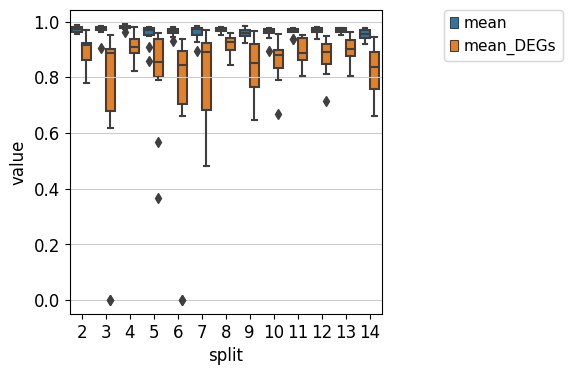

In [73]:
# plt.figure()
ax = sns.boxplot(x="split", y="value", hue="eval_type",data=holdout)
fig = ax.get_figure()
# plt.legend([],[], frameon=False)
plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
fig.savefig("./figures/multiple_split_mean.pdf") 

No handles with labels found to put in legend.


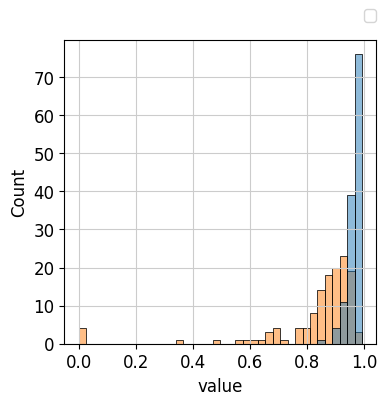

In [74]:
ax = sns.histplot(x="value", hue="eval_type",data=holdout)
fig = ax.get_figure()
# plt.legend([],[], frameon=False)
plt.legend(bbox_to_anchor=(1, 1.1),borderaxespad=0)
fig.savefig("./figures/multiple_split_mean_hist.pdf")

In [75]:
num_dic = dict(adata.obs.cov_drug_dose_name.value_counts())
num_list = [num_dic[i] for i in list(var.pert_name)]
mean["n_samples"] = num_list

<ipython-input-75-f35a95ce426e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean["n_samples"] = num_list


In [76]:
holdout_bad = holdout[holdout.value<0.4]

In [77]:
holdout_bad.groupby("split")["pert_name"].value_counts()

split  pert_name             
3      A549_KIF18B+KIF2C_1+1     1
       A549_PLK4+STIL_1+1        1
5      A549_JUN+CEBPA_1+1        1
6      A549_C3orf72+FOXL2_1+1    1
       A549_CBL+UBASH3A_1+1      1
Name: pert_name, dtype: int64

In [78]:
adata_bad = adata[adata.obs["cov_drug_dose_name"].isin(holdout_bad.pert_name.unique())]

In [79]:
adata_bad.obs["condition"].value_counts()

KIF18B+KIF2C     96
PLK4+STIL        81
CBL+UBASH3A      64
C3orf72+FOXL2    59
JUN+CEBPA        54
Name: condition, dtype: int64

In [80]:
to_counts = {}
for i in adata_bad.obs["condition"].unique():
    splited = i.split("+")
    to_counts[splited[0]] = []
    to_counts[splited[1]] = []
    for j in splited:
        for k in adata.obs["condition"].unique():
            if j in k:
               to_counts[j].append(k)

In [81]:
to_counts

{'JUN': ['JUN+CEBPA', 'JUN+ctrl', 'JUN+CEBPB'],
 'CEBPA': ['JUN+CEBPA',
  'CEBPA+ctrl',
  'ctrl+CEBPA',
  'CEBPE+CEBPA',
  'CEBPB+CEBPA',
  'KLF1+CEBPA',
  'ZC3HAV1+CEBPA'],
 'KIF18B': ['KIF18B+KIF2C', 'KIF18B+ctrl'],
 'KIF2C': ['KIF18B+KIF2C', 'KIF2C+ctrl', 'ctrl+KIF2C'],
 'CBL': ['CBL+PTPN9',
  'CBL+ctrl',
  'CBL+UBASH3A',
  'CBL+CNN1',
  'CBL+UBASH3B',
  'CBL+TGFBR2',
  'CBL+PTPN12'],
 'UBASH3A': ['UBASH3B+UBASH3A',
  'PTPN12+UBASH3A',
  'CNN1+UBASH3A',
  'CBL+UBASH3A',
  'ctrl+UBASH3A',
  'UBASH3A+ctrl'],
 'PLK4': ['PLK4+ctrl', 'PLK4+STIL'],
 'STIL': ['ctrl+STIL', 'STIL+ctrl', 'PLK4+STIL'],
 'C3orf72': ['C3orf72+ctrl', 'C3orf72+FOXL2'],
 'FOXL2': ['ZNF318+FOXL2',
  'POU3F2+FOXL2',
  'FOXL2+MEIS1',
  'FOXL2+ctrl',
  'FOXA1+FOXL2',
  'FOXF1+FOXL2',
  'FOXL2+HOXB9',
  'ctrl+FOXL2',
  'FOXA3+FOXL2',
  'C3orf72+FOXL2']}

In [82]:
sc.set_figure_params(dpi=100, frameon=False,fontsize=12)


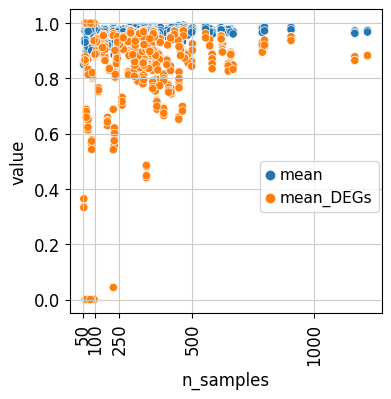

In [90]:
g= sns.scatterplot(data=mean, x="n_samples", y="value", hue="eval_type")
# g.set(xlim = [ 0, 50,100,200,  500., 1000., 1500., 2000.])
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_xticks()]
g.set_xticks([50,100,200,500,1000])
g.set_xticklabels([50,100,250,500,1000],rotation=90)
fig = g.get_figure()
plt.legend(bbox_to_anchor=(.99, 0.5),borderaxespad=0)
fig.savefig("./figures/r2_means_samples.pdf") 

In [84]:
num_dic = dict(adata.obs.cov_drug_dose_name.value_counts())
num_list = [num_dic[i] for i in list(var_hd.pert_name)]
var_hd["n_samples"] = num_list

<ipython-input-84-812d35bf70ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_hd["n_samples"] = num_list


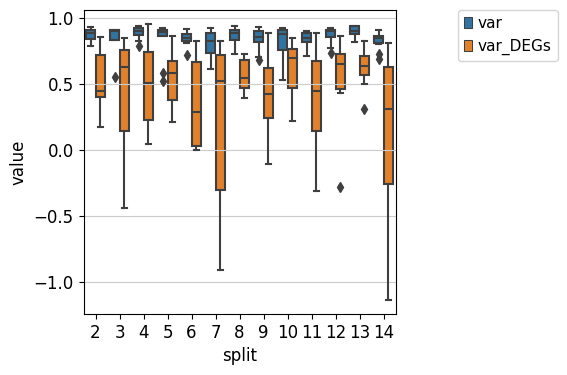

In [85]:
ax = sns.boxplot(x="split", y="value", hue="eval_type",data=var_hd)
fig = ax.get_figure()
plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
fig.savefig("./figures/multiple_splits_var_hist.pdf") 

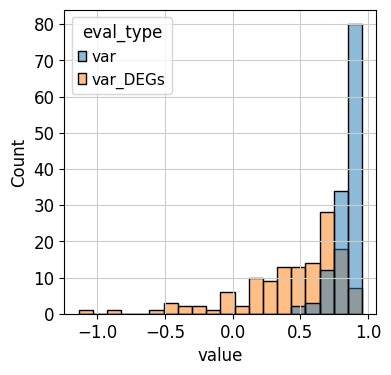

In [89]:
ax = sns.histplot(x="value", hue="eval_type",data=var_hd)
fig = ax.get_figure()
# plt.legend([],[], frameon=False)
# plt.legend(bbox_to_anchor=(1.1, 1),borderaxespad=0)
fig.savefig("./figures/multiple_split_hist_var.pdf")

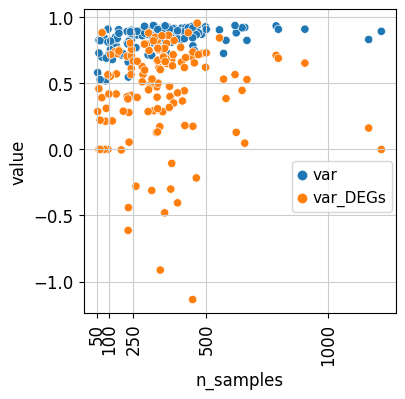

In [88]:
g= sns.scatterplot(data=var_hd, x="n_samples", y="value", hue="eval_type")
# g.set(xlim = [ 0, 50,100,200,  500., 1000., 1500., 2000.])
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_xticks()]
g.set_xticks([50,100,200,500,1000])
g.set_xticklabels([50,100,250,500,1000],rotation=90)
fig = g.get_figure()
plt.legend(bbox_to_anchor=(0.99, 0.5),borderaxespad=0)
fig.savefig("./figures/r2_vars_samples.pdf") 

## analysis of  increasing  combinations

In [91]:
holdout = mean[mean.split.isin(['23', '15','16','17','18','19','20'])]
var_hd =  var[var.split.isin([ '23','15','16','17','18','19','20'])]

In [92]:
holdout[holdout.split == "18"]

,pert_name,split,eval_type,value,n_samples
0,A549_BCL2L11+TGFBR2_1+1,18,mean,0.984967,463
1,A549_BPGM+SAMD1_1+1,18,mean,0.976005,301
2,A549_CBL+PTPN12_1+1,18,mean,0.969246,335
3,A549_CDKN1C+CDKN1B_1+1,18,mean,0.979854,107
4,A549_CEBPB+CEBPA_1+1,18,mean,0.897728,64
...,...,...,...,...,...
55,A549_ZBTB10+DLX2_1+1,18,mean_DEGs,0.810978,89
56,A549_ZBTB10+PTPN12_1+1,18,mean_DEGs,0.938020,265
57,A549_ZBTB10+SNAI1_1+1,18,mean_DEGs,0.886613,100
58,A549_ZC3HAV1+CEBPE_1+1,18,mean_DEGs,0.952464,410


In [93]:
order = ['23', '15','16','17','18','19','20']

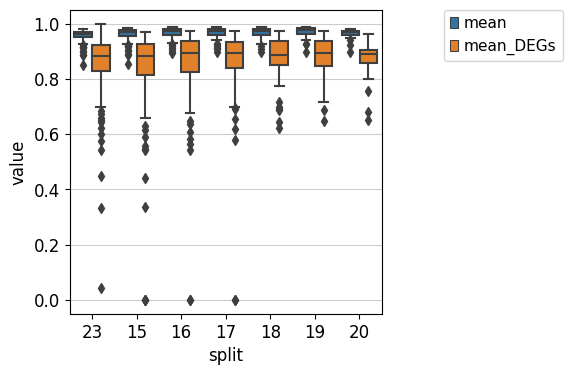

In [94]:
ax = sns.boxplot(x="split", y="value", hue="eval_type",data=holdout, order= order)
fig = ax.get_figure()
plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
fig.savefig("./figures/split_robustness_mean.pdf") 

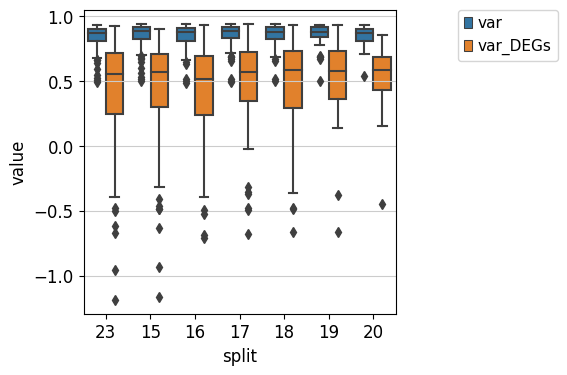

In [95]:
ax = sns.boxplot(x="split", y="value", hue="eval_type",data=var_hd, order=order)
fig = ax.get_figure()
plt.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
fig.savefig("./figures/split_robustness_var.pdf") 